# モンテカルロ法 (Monte Carlo Methods) の理解

## 目次
1. モンテカルロ法とは
2. 基本原理：大数の法則
3. 例1: 円周率πの近似計算
4. 例2: 定積分の計算
5. 例3: 確率的シミュレーション（ビュッフォンの針）
6. 例4: モンテカルロ積分
7. 収束性の分析

In [5]:
# 必要なライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
from typing import Callable

# 日本語フォントの設定
rcParams['font.sans-serif'] = ['DejaVu Sans']
rcParams['axes.unicode_minus'] = False

# 乱数シードの設定（再現性のため）
np.random.seed(42)

print("ライブラリのインポート完了")

ライブラリのインポート完了


## 1. モンテカルロ法とは

**モンテカルロ法**は、乱数を用いたシミュレーションによって数値計算を行う手法です。

### 主な特徴
- 🎲 **乱数ベース**: ランダムサンプリングを利用
- 📊 **統計的アプローチ**: 大数の法則に基づく
- 🔄 **収束**: サンプル数を増やすほど精度が向上
- 🌍 **汎用性**: 様々な問題に適用可能

### 基本原理
大数の法則により、十分に大きなサンプルサイズNを用いると、サンプル平均は真の期待値に収束します。

$$\bar{X}_N = \frac{1}{N}\sum_{i=1}^{N} X_i \xrightarrow{N\to\infty} E[X]$$

## 2. 基本原理：大数の法則の確認

まず、モンテカルロ法の基礎となる大数の法則を視覚的に確認します。

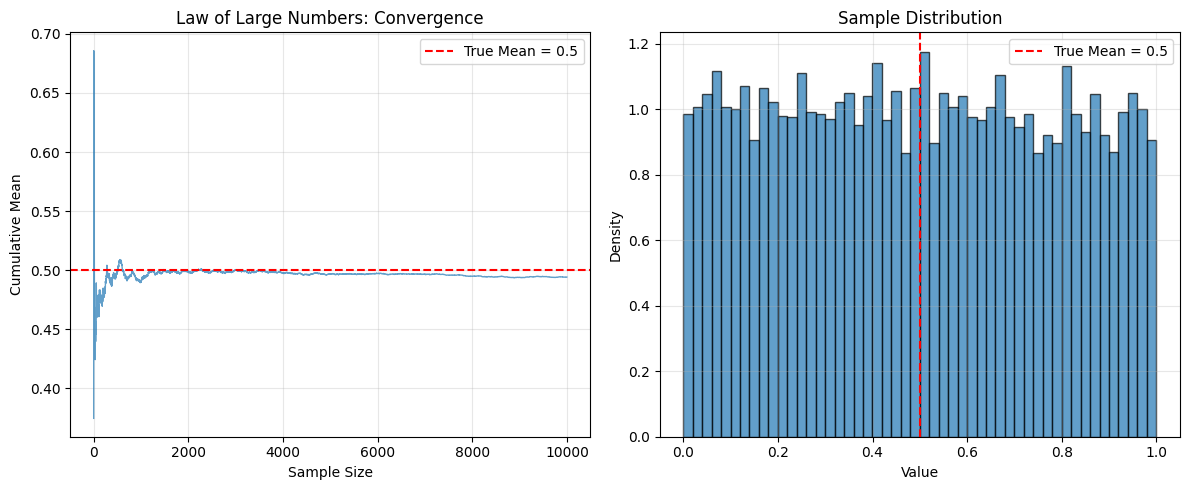

Final cumulative mean: 0.494160
Error from true mean: 0.005840


In [6]:
def demonstrate_law_of_large_numbers(n_samples: int = 10000):
    """
    大数の法則を視覚的に示すデモンストレーション
    
    Args:
        n_samples: サンプル数
    """
    # 一様分布 [0, 1] からサンプリング（期待値 = 0.5）
    samples = np.random.uniform(0, 1, n_samples)
    
    # 累積平均を計算
    cumulative_mean = np.cumsum(samples) / np.arange(1, n_samples + 1)
    
    # プロット
    plt.figure(figsize=(12, 5))
    
    # 左図: 累積平均の収束
    plt.subplot(1, 2, 1)
    plt.plot(cumulative_mean, linewidth=1, alpha=0.7)
    plt.axhline(y=0.5, color='r', linestyle='--', label='True Mean = 0.5')
    plt.xlabel('Sample Size')
    plt.ylabel('Cumulative Mean')
    plt.title('Law of Large Numbers: Convergence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 右図: サンプル分布のヒストグラム
    plt.subplot(1, 2, 2)
    plt.hist(samples, bins=50, density=True, alpha=0.7, edgecolor='black')
    plt.axvline(x=0.5, color='r', linestyle='--', label='True Mean = 0.5')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Sample Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Final cumulative mean: {cumulative_mean[-1]:.6f}")
    print(f"Error from true mean: {abs(cumulative_mean[-1] - 0.5):.6f}")

# 実行
demonstrate_law_of_large_numbers(10000)

## 3. 例1: 円周率πの近似計算

### アルゴリズムの原理

1. 単位正方形 [0,1] × [0,1] 内にランダムに点を生成
2. 各点が単位円（半径1の1/4円）内にあるか判定
3. 円内の点の割合から π を推定

### 数学的背景
- 正方形の面積: $A_{square} = 1$
- 1/4円の面積: $A_{circle} = \frac{\pi r^2}{4} = \frac{\pi}{4}$ (r=1のとき)
- 点が円内に入る確率: $P = \frac{\pi}{4}$
- したがって: $\pi \approx 4 \times \frac{\text{円内の点数}}{\text{全点数}}$

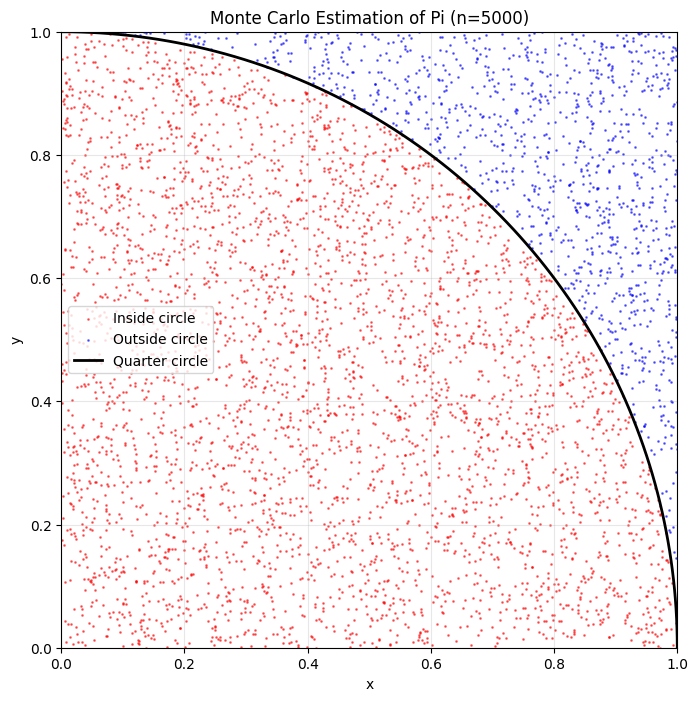

Estimated π: 3.135200
True π: 3.141593
Error: 0.006393


In [7]:
class PiEstimator:
    """
    モンテカルロ法による円周率πの推定クラス
    """
    
    def __init__(self):
        self.points_inside = 0
        self.total_points = 0
        self.history = []
    
    def generate_point(self) -> tuple:
        """
        [0, 1] × [0, 1] 内にランダムな点を生成
        
        Returns:
            (x, y): 生成された点の座標
        """
        x = np.random.uniform(0, 1)
        y = np.random.uniform(0, 1)
        return x, y
    
    def is_inside_circle(self, x: float, y: float) -> bool:
        """
        点が単位円内にあるか判定
        
        Args:
            x, y: 点の座標
            
        Returns:
            True if 点が円内, False otherwise
        """
        # 原点からの距離の二乗を計算
        distance_squared = x**2 + y**2
        return distance_squared <= 1.0
    
    def estimate_pi(self, n_samples: int) -> float:
        """
        モンテカルロ法でπを推定
        
        Args:
            n_samples: サンプル点数
            
        Returns:
            推定されたπの値
        """
        inside_count = 0
        
        for _ in range(n_samples):
            x, y = self.generate_point()
            if self.is_inside_circle(x, y):
                inside_count += 1
        
        # π = 4 × (円内の点数 / 全点数)
        pi_estimate = 4.0 * inside_count / n_samples
        
        self.points_inside += inside_count
        self.total_points += n_samples
        self.history.append(pi_estimate)
        
        return pi_estimate
    
    def visualize(self, n_points: int = 5000):
        """
        サンプル点と円を可視化
        
        Args:
            n_points: 表示する点の数
        """
        # 点を生成
        points_x = np.random.uniform(0, 1, n_points)
        points_y = np.random.uniform(0, 1, n_points)
        
        # 円内外を判定
        distances = points_x**2 + points_y**2
        inside = distances <= 1.0
        
        # プロット
        plt.figure(figsize=(8, 8))
        
        # 円内の点（赤）
        plt.scatter(points_x[inside], points_y[inside], 
                   c='red', s=1, alpha=0.5, label='Inside circle')
        
        # 円外の点（青）
        plt.scatter(points_x[~inside], points_y[~inside], 
                   c='blue', s=1, alpha=0.5, label='Outside circle')
        
        # 1/4円を描画
        theta = np.linspace(0, np.pi/2, 100)
        circle_x = np.cos(theta)
        circle_y = np.sin(theta)
        plt.plot(circle_x, circle_y, 'black', linewidth=2, label='Quarter circle')
        
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.gca().set_aspect('equal')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'Monte Carlo Estimation of Pi (n={n_points})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # π の推定
        pi_est = 4.0 * np.sum(inside) / n_points
        print(f"Estimated π: {pi_est:.6f}")
        print(f"True π: {np.pi:.6f}")
        print(f"Error: {abs(pi_est - np.pi):.6f}")

# πの推定を実行
estimator = PiEstimator()
estimator.visualize(5000)

 Sample Size  Estimated π    Error
         100      3.32000 0.178407
         500      3.08800 0.053593
        1000      3.04000 0.101593
        5000      3.15360 0.012007
       10000      3.15320 0.011607
       50000      3.14792 0.006327
      100000      3.14264 0.001047

True π = 3.1415926536


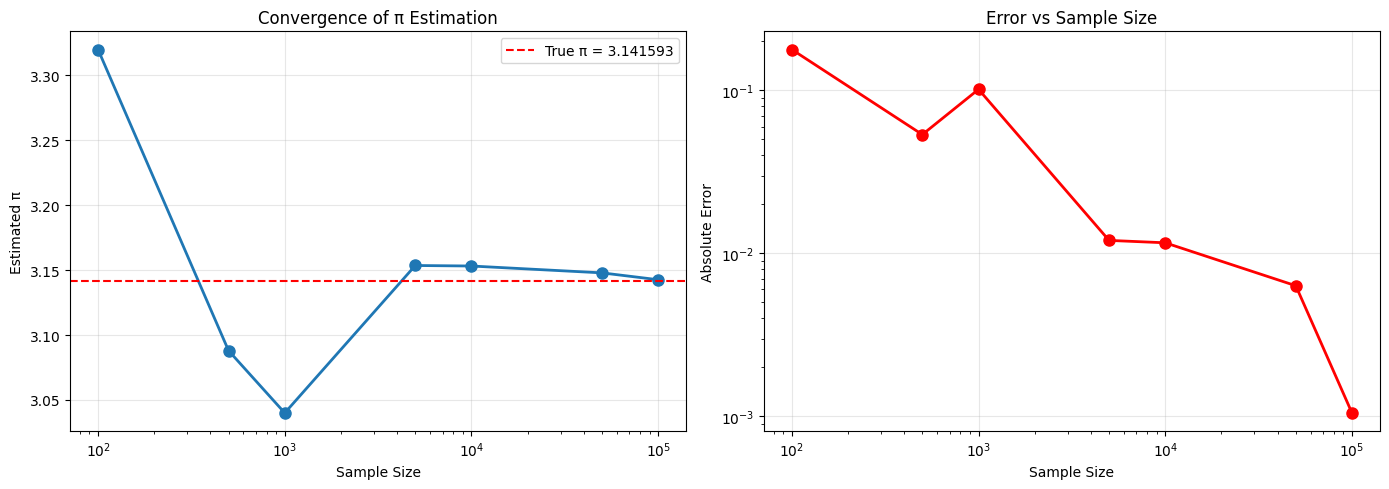

In [8]:
# 収束性の分析
def analyze_pi_convergence():
    """
    サンプル数を変えてπの推定精度を分析
    """
    sample_sizes = [100, 500, 1000, 5000, 10000, 50000, 100000]
    estimates = []
    errors = []
    
    for n in sample_sizes:
        estimator = PiEstimator()
        pi_est = estimator.estimate_pi(n)
        estimates.append(pi_est)
        errors.append(abs(pi_est - np.pi))
    
    # 結果をDataFrameにまとめる
    df = pd.DataFrame({
        'Sample Size': sample_sizes,
        'Estimated π': estimates,
        'Error': errors
    })
    
    print(df.to_string(index=False))
    print(f"\nTrue π = {np.pi:.10f}")
    
    # プロット
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 推定値の収束
    ax1.plot(sample_sizes, estimates, 'o-', linewidth=2, markersize=8)
    ax1.axhline(y=np.pi, color='r', linestyle='--', label=f'True π = {np.pi:.6f}')
    ax1.set_xlabel('Sample Size')
    ax1.set_ylabel('Estimated π')
    ax1.set_title('Convergence of π Estimation')
    ax1.set_xscale('log')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 誤差の減少
    ax2.plot(sample_sizes, errors, 'o-', linewidth=2, markersize=8, color='red')
    ax2.set_xlabel('Sample Size')
    ax2.set_ylabel('Absolute Error')
    ax2.set_title('Error vs Sample Size')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

analyze_pi_convergence()

## 4. 例2: 定積分の計算

モンテカルロ法は定積分の数値計算に利用可能

### 問題設定
$$I = \int_a^b f(x) dx$$

### モンテカルロ積分の原理
区間 [a, b] から一様にN個の点 $x_i$ をサンプリングすると：

$$I \approx \frac{b-a}{N} \sum_{i=1}^{N} f(x_i)$$

=== Example 1: ∫sin(x)dx from 0 to π ===


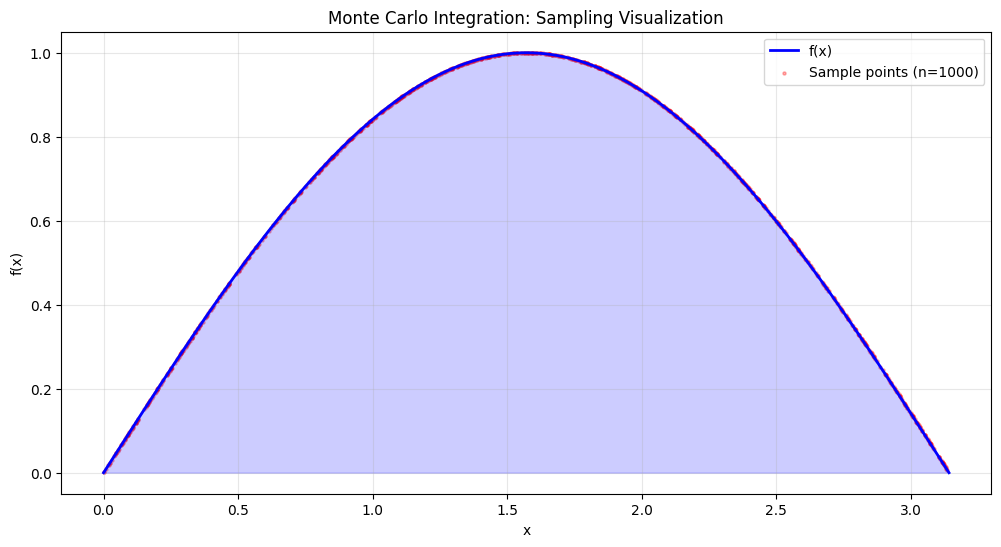

Estimated integral: 1.982442 ± 0.031030
True value: 2.000000


In [9]:
class MonteCarloIntegrator:
    """
    モンテカルロ法による数値積分クラス
    """
    
    def __init__(self, func: Callable, a: float, b: float):
        """
        Args:
            func: 積分する関数
            a: 積分区間の下限
            b: 積分区間の上限
        """
        self.func = func
        self.a = a
        self.b = b
    
    def integrate(self, n_samples: int) -> float:
        """
        モンテカルロ積分を実行
        
        Args:
            n_samples: サンプル点数
            
        Returns:
            積分値の推定
        """
        # [a, b] 区間で一様にサンプリング
        x_samples = np.random.uniform(self.a, self.b, n_samples)
        
        # 各点で関数値を計算
        f_values = self.func(x_samples)
        
        # モンテカルロ積分の公式
        integral = (self.b - self.a) * np.mean(f_values)
        
        return integral
    
    def integrate_with_variance(self, n_samples: int) -> tuple:
        """
        分散も計算するバージョン
        
        Returns:
            (積分値, 標準誤差)
        """
        x_samples = np.random.uniform(self.a, self.b, n_samples)
        f_values = self.func(x_samples)
        
        integral = (self.b - self.a) * np.mean(f_values)
        
        # 標準誤差の計算
        variance = np.var(f_values)
        std_error = (self.b - self.a) * np.sqrt(variance / n_samples)
        
        return integral, std_error
    
    def visualize_sampling(self, n_samples: int = 1000):
        """
        サンプリング点と関数を可視化
        """
        # サンプル点
        x_samples = np.random.uniform(self.a, self.b, n_samples)
        y_samples = self.func(x_samples)
        
        # プロット用の細かいグリッド
        x_plot = np.linspace(self.a, self.b, 1000)
        y_plot = self.func(x_plot)
        
        plt.figure(figsize=(12, 6))
        
        # 関数の曲線
        plt.plot(x_plot, y_plot, 'b-', linewidth=2, label='f(x)')
        
        # サンプル点
        plt.scatter(x_samples, y_samples, c='red', s=5, alpha=0.3, 
                   label=f'Sample points (n={n_samples})')
        
        # 積分領域を塗りつぶし
        plt.fill_between(x_plot, 0, y_plot, alpha=0.2, color='blue')
        
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.title('Monte Carlo Integration: Sampling Visualization')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # 積分値を計算
        integral, std_error = self.integrate_with_variance(n_samples)
        print(f"Estimated integral: {integral:.6f} ± {std_error:.6f}")

# 例: sin(x) を [0, π] で積分
print("=== Example 1: ∫sin(x)dx from 0 to π ===")
integrator1 = MonteCarloIntegrator(np.sin, 0, np.pi)
integrator1.visualize_sampling(1000)
print(f"True value: {2.0:.6f}")  # ∫sin(x)dx from 0 to π = 2


=== Example 2: ∫x²dx from 0 to 1 ===


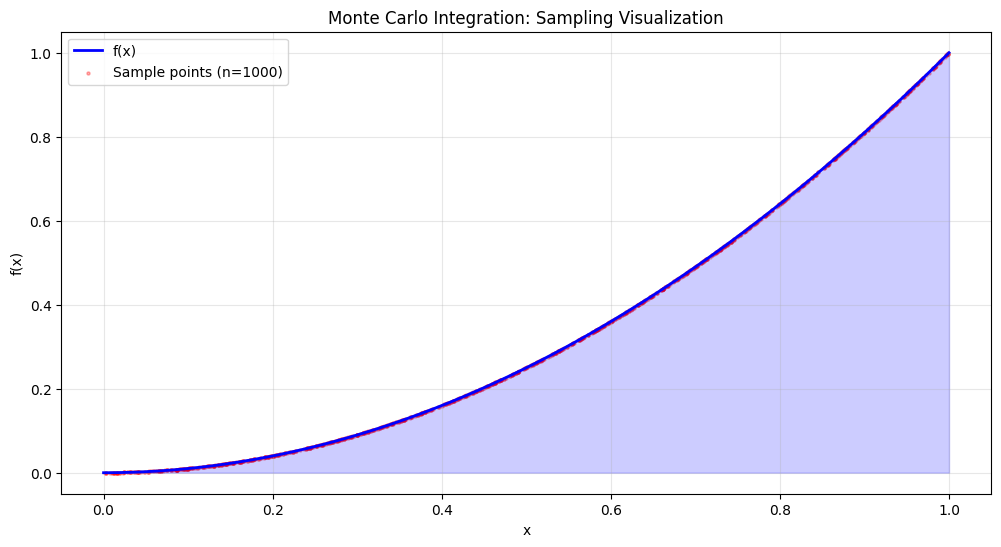

Estimated integral: 0.339102 ± 0.009534
True value: 0.333333


In [10]:
# 例: x^2 を [0, 1] で積分
print("\n=== Example 2: ∫x²dx from 0 to 1 ===")
integrator2 = MonteCarloIntegrator(lambda x: x**2, 0, 1)
integrator2.visualize_sampling(1000)
print(f"True value: {1/3:.6f}")  # ∫x²dx from 0 to 1 = 1/3

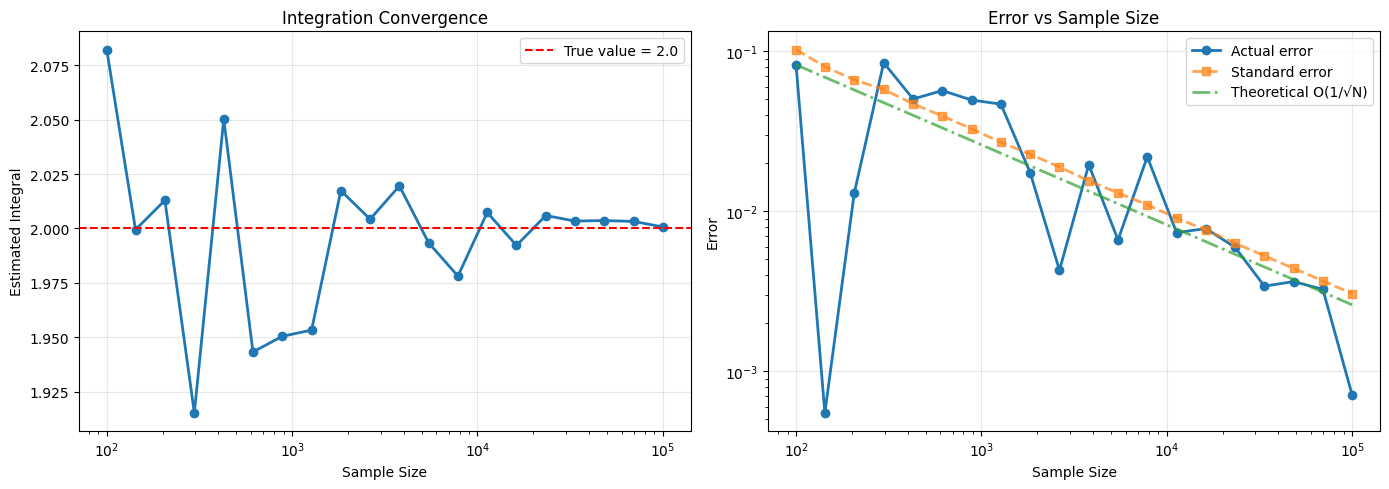

In [11]:
# 収束性の分析
def analyze_integration_convergence():
    """
    積分の収束性を分析
    """
    # テスト関数: sin(x) on [0, π]
    integrator = MonteCarloIntegrator(np.sin, 0, np.pi)
    true_value = 2.0
    
    sample_sizes = np.logspace(2, 5, 20, dtype=int)
    estimates = []
    errors = []
    std_errors = []
    
    for n in sample_sizes:
        integral, std_error = integrator.integrate_with_variance(n)
        estimates.append(integral)
        errors.append(abs(integral - true_value))
        std_errors.append(std_error)
    
    # プロット
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 推定値の収束
    ax1.plot(sample_sizes, estimates, 'o-', linewidth=2, markersize=6)
    ax1.axhline(y=true_value, color='r', linestyle='--', 
               label=f'True value = {true_value}')
    ax1.set_xlabel('Sample Size')
    ax1.set_ylabel('Estimated Integral')
    ax1.set_title('Integration Convergence')
    ax1.set_xscale('log')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 誤差とO(1/√N)の理論曲線
    ax2.plot(sample_sizes, errors, 'o-', linewidth=2, markersize=6, 
            label='Actual error')
    ax2.plot(sample_sizes, std_errors, 's--', linewidth=2, markersize=6,
            label='Standard error', alpha=0.7)
    
    # 理論的な1/√N曲線を追加
    theoretical = errors[0] * np.sqrt(sample_sizes[0] / sample_sizes)
    ax2.plot(sample_sizes, theoretical, '-.', linewidth=2, 
            label='Theoretical O(1/√N)', alpha=0.7)
    
    ax2.set_xlabel('Sample Size')
    ax2.set_ylabel('Error')
    ax2.set_title('Error vs Sample Size')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

analyze_integration_convergence()

## 5. 例3: ビュッフォンの針問題

**ビュッフォンの針**は、古典的な幾何確率問題で、モンテカルロ法の応用例としてあるそうです。

### 問題設定
- 床に平行な線が間隔 $d$ で引かれている
- 長さ $l$ (ただし $l \leq d$) の針をランダムに落とす
- 針が線と交わる確率は？

### 理論的解
$$P = \frac{2l}{\pi d}$$

この式から π を推定できます：
$$\pi = \frac{2l}{Pd}$$

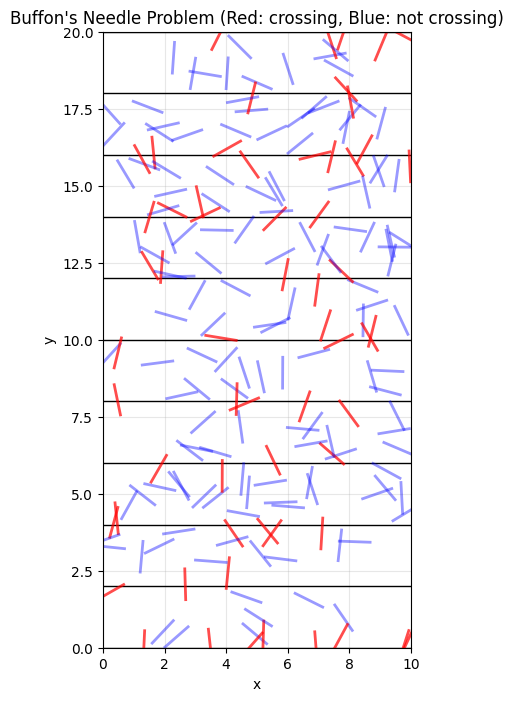

Crossing probability: 0.3000
Theoretical probability: 0.3183
Estimated π: 3.3333
True π: 3.1416


In [12]:
class BuffonNeedle:
    """
    バッファォンの針問題のシミュレーション
    """
    
    def __init__(self, needle_length: float, line_distance: float):
        """
        Args:
            needle_length: 針の長さ l
            line_distance: 線の間隔 d
        """
        assert needle_length <= line_distance, "針の長さは線の間隔以下である必要があります"
        self.l = needle_length
        self.d = line_distance
    
    def drop_needle(self) -> bool:
        """
        針を1回落とし、線と交わるか判定
        
        Returns:
            True if 針が線と交わる, False otherwise
        """
        # 針の中心のy座標（0からd/2の範囲）
        y_center = np.random.uniform(0, self.d / 2)
        
        # 針の角度θ（0からπの範囲）
        theta = np.random.uniform(0, np.pi)
        
        # 針の端点のy座標
        y_end = y_center + (self.l / 2) * np.sin(theta)
        
        # 線と交わる条件: y_end > d/2 または y_end < 0
        return y_end > self.d / 2 or y_end < 0
    
    def simulate(self, n_drops: int) -> tuple:
        """
        シミュレーションを実行
        
        Args:
            n_drops: 針を落とす回数
            
        Returns:
            (交差確率, π推定値)
        """
        crossings = sum(self.drop_needle() for _ in range(n_drops))
        
        # 交差確率
        probability = crossings / n_drops
        
        # πの推定
        if probability > 0:
            pi_estimate = (2 * self.l) / (probability * self.d)
        else:
            pi_estimate = float('inf')
        
        return probability, pi_estimate
    
    def visualize(self, n_needles: int = 100):
        """
        針の落下を可視化
        
        Args:
            n_needles: 表示する針の数
        """
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # 平行線を描画
        n_lines = 10
        for i in range(n_lines + 1):
            y_line = i * self.d
            ax.axhline(y=y_line, color='black', linewidth=1)
        
        # 針を落とす
        crossings = 0
        for _ in range(n_needles):
            # 針の中心位置
            x_center = np.random.uniform(0, 10)
            y_center = np.random.uniform(0, n_lines * self.d)
            
            # 針の角度
            theta = np.random.uniform(0, np.pi)
            
            # 針の端点
            x1 = x_center - (self.l / 2) * np.cos(theta)
            y1 = y_center - (self.l / 2) * np.sin(theta)
            x2 = x_center + (self.l / 2) * np.cos(theta)
            y2 = y_center + (self.l / 2) * np.sin(theta)
            
            # 交差判定（最も近い線との距離を計算）
            nearest_line = round(y_center / self.d) * self.d
            crosses = abs(y_center - nearest_line) < (self.l / 2) * abs(np.sin(theta))
            
            if crosses:
                crossings += 1
                color = 'red'
                alpha = 0.7
            else:
                color = 'blue'
                alpha = 0.4
            
            # 針を描画
            ax.plot([x1, x2], [y1, y2], color=color, linewidth=2, alpha=alpha)
        
        ax.set_xlim(0, 10)
        ax.set_ylim(0, n_lines * self.d)
        ax.set_aspect('equal')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f"Buffon's Needle Problem (Red: crossing, Blue: not crossing)")
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # 結果
        prob = crossings / n_needles
        if prob > 0:
            pi_est = (2 * self.l) / (prob * self.d)
        else:
            pi_est = float('inf')
        
        print(f"Crossing probability: {prob:.4f}")
        print(f"Theoretical probability: {(2 * self.l) / (np.pi * self.d):.4f}")
        print(f"Estimated π: {pi_est:.4f}")
        print(f"True π: {np.pi:.4f}")

# シミュレーション実行
buffon = BuffonNeedle(needle_length=1.0, line_distance=2.0)
buffon.visualize(200)

 Drops  Estimated π    Error
   100     3.125000 0.016593
   500     3.067485 0.074108
  1000     3.076923 0.064670
  5000     3.107520 0.034072
 10000     3.127932 0.013660
 50000     3.128324 0.013269
100000     3.126172 0.015420


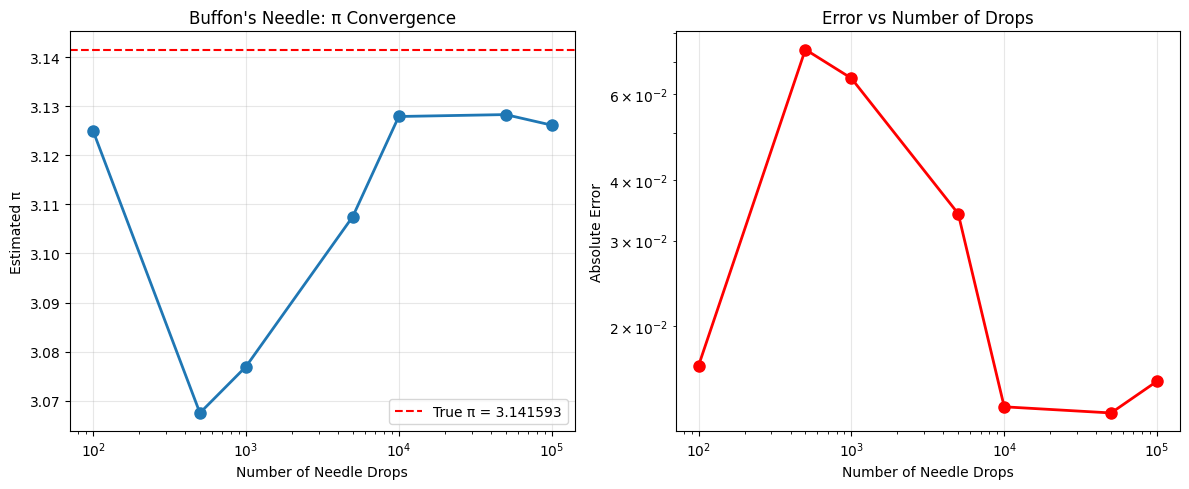

In [13]:
# 大規模シミュレーションで精度を確認
def analyze_buffon_convergence():
    """
    バッファォンの針のシミュレーション収束性を分析
    """
    buffon = BuffonNeedle(needle_length=1.0, line_distance=2.0)
    
    sample_sizes = [100, 500, 1000, 5000, 10000, 50000, 100000]
    pi_estimates = []
    errors = []
    
    for n in sample_sizes:
        prob, pi_est = buffon.simulate(n)
        pi_estimates.append(pi_est)
        errors.append(abs(pi_est - np.pi))
    
    # 結果表示
    df = pd.DataFrame({
        'Drops': sample_sizes,
        'Estimated π': pi_estimates,
        'Error': errors
    })
    print(df.to_string(index=False))
    
    # プロット
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(sample_sizes, pi_estimates, 'o-', linewidth=2, markersize=8)
    plt.axhline(y=np.pi, color='r', linestyle='--', label=f'True π = {np.pi:.6f}')
    plt.xlabel('Number of Needle Drops')
    plt.ylabel('Estimated π')
    plt.title("Buffon's Needle: π Convergence")
    plt.xscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(sample_sizes, errors, 'o-', linewidth=2, markersize=8, color='red')
    plt.xlabel('Number of Needle Drops')
    plt.ylabel('Absolute Error')
    plt.title('Error vs Number of Drops')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

analyze_buffon_convergence()

## 6. 多次元積分の例

モンテカルロ法は高次元積分で特に威力を発揮します。

### 2次元積分の例
$$I = \int\int_D f(x, y) \, dx\,dy$$

### モンテカルロ推定
$$I \approx \frac{\text{Area}(D)}{N} \sum_{i=1}^{N} f(x_i, y_i)$$

=== 2D Integration: ∫∫(x² + y²)dxdy over [0,1]×[0,1] ===


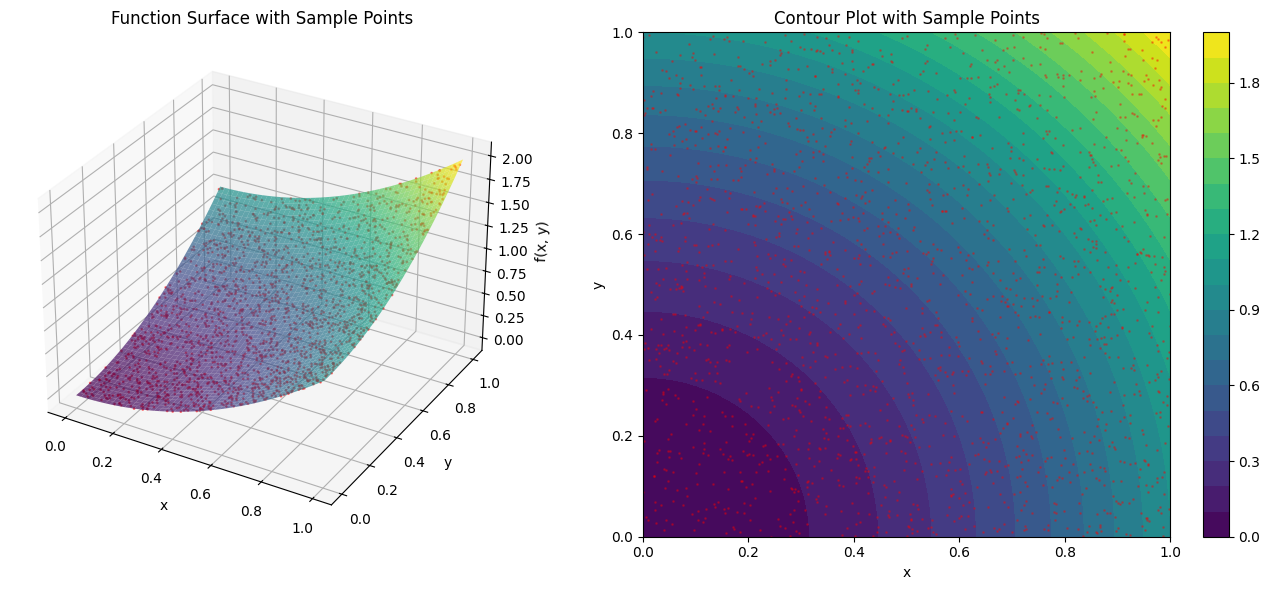

Estimated integral: 0.669881
True value: 0.666667


In [14]:
class MonteCarloIntegrator2D:
    """
    2次元モンテカルロ積分
    """
    
    def __init__(self, func: Callable, x_range: tuple, y_range: tuple):
        """
        Args:
            func: 2変数関数 f(x, y)
            x_range: x の範囲 (x_min, x_max)
            y_range: y の範囲 (y_min, y_max)
        """
        self.func = func
        self.x_min, self.x_max = x_range
        self.y_min, self.y_max = y_range
        self.area = (self.x_max - self.x_min) * (self.y_max - self.y_min)
    
    def integrate(self, n_samples: int) -> float:
        """
        2次元モンテカルロ積分
        """
        # ランダムサンプリング
        x_samples = np.random.uniform(self.x_min, self.x_max, n_samples)
        y_samples = np.random.uniform(self.y_min, self.y_max, n_samples)
        
        # 関数値の計算
        f_values = self.func(x_samples, y_samples)
        
        # 積分値
        integral = self.area * np.mean(f_values)
        
        return integral
    
    def visualize(self, n_samples: int = 1000):
        """
        3Dプロットで可視化
        """
        from mpl_toolkits.mplot3d import Axes3D
        
        # グリッドでプロット
        x_grid = np.linspace(self.x_min, self.x_max, 50)
        y_grid = np.linspace(self.y_min, self.y_max, 50)
        X, Y = np.meshgrid(x_grid, y_grid)
        Z = self.func(X, Y)
        
        # サンプル点
        x_samples = np.random.uniform(self.x_min, self.x_max, n_samples)
        y_samples = np.random.uniform(self.y_min, self.y_max, n_samples)
        z_samples = self.func(x_samples, y_samples)
        
        fig = plt.figure(figsize=(14, 6))
        
        # 3D サーフェス
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)
        ax1.scatter(x_samples, y_samples, z_samples, c='red', s=1, alpha=0.5)
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_zlabel('f(x, y)')
        ax1.set_title('Function Surface with Sample Points')
        
        # 上から見た図（等高線）
        ax2 = fig.add_subplot(122)
        contour = ax2.contourf(X, Y, Z, levels=20, cmap='viridis')
        ax2.scatter(x_samples, y_samples, c='red', s=1, alpha=0.3)
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_title('Contour Plot with Sample Points')
        plt.colorbar(contour, ax=ax2)
        
        plt.tight_layout()
        plt.show()
        
        # 積分値
        integral = self.integrate(n_samples)
        print(f"Estimated integral: {integral:.6f}")

# 例: f(x,y) = x^2 + y^2 を [0,1]×[0,1] で積分
print("=== 2D Integration: ∫∫(x² + y²)dxdy over [0,1]×[0,1] ===")
integrator_2d = MonteCarloIntegrator2D(
    lambda x, y: x**2 + y**2,
    x_range=(0, 1),
    y_range=(0, 1)
)
integrator_2d.visualize(2000)
print(f"True value: {2/3:.6f}")  # ∫∫(x² + y²)dxdy = 2/3

## 7. まとめと収束率の分析

### モンテカルロ法の重要な性質

1. **収束率**: $O(N^{-1/2})$
   - 誤差は標本数の平方根に反比例
   - 精度を10倍にするには、サンプル数を100倍に

2. **次元の呪い**
   - 高次元でも収束率は変わらない
   - 決定論的手法（台形則など)は高次元で困難

3. **並列化が容易**
   - 各サンプルが独立
   - 大規模並列計算に適している

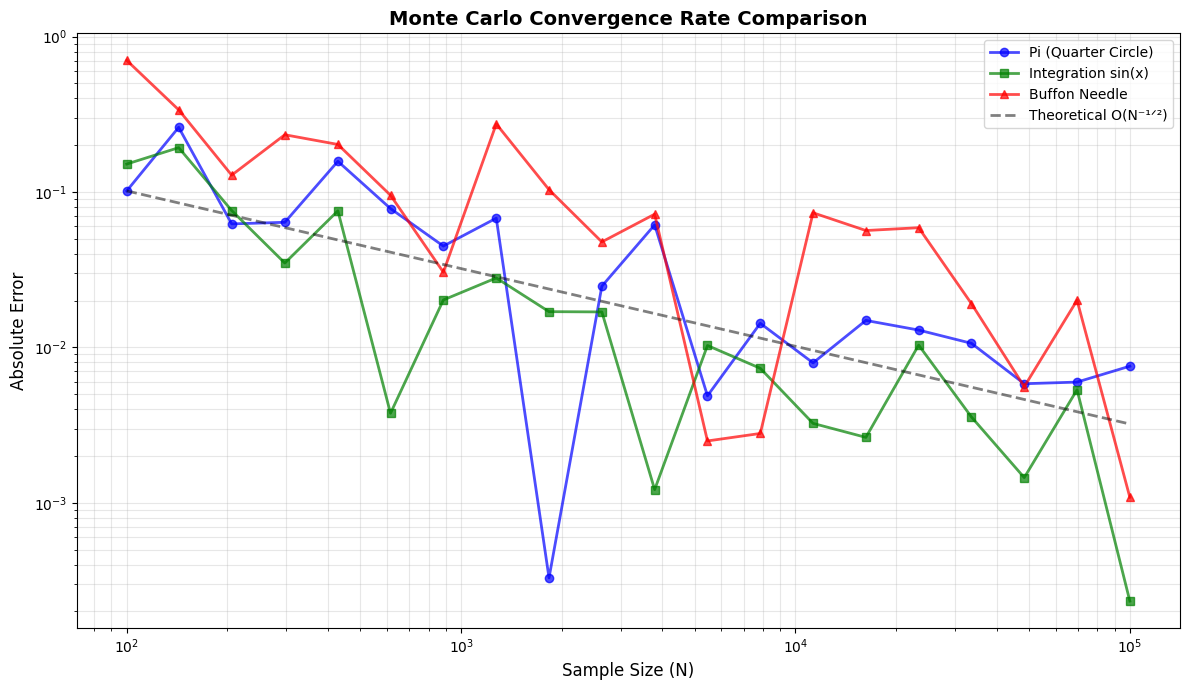


=== Convergence Analysis ===
All methods show O(N^(-1/2)) convergence rate
To reduce error by 10x, need 100x more samples


In [15]:
def compare_convergence_rates():
    """
    様々な問題でのモンテカルロ法の収束率を比較
    """
    sample_sizes = np.logspace(2, 5, 20, dtype=int)
    
    # 各問題のエラーを記録
    results = {
        'Pi (Quarter Circle)': [],
        'Integration sin(x)': [],
        'Buffon Needle': []
    }
    
    for n in sample_sizes:
        # π推定（円）
        pi_est = PiEstimator()
        pi_val = pi_est.estimate_pi(n)
        results['Pi (Quarter Circle)'].append(abs(pi_val - np.pi))
        
        # 積分
        integrator = MonteCarloIntegrator(np.sin, 0, np.pi)
        int_val = integrator.integrate(n)
        results['Integration sin(x)'].append(abs(int_val - 2.0))
        
        # バッファォンの針
        buffon = BuffonNeedle(1.0, 2.0)
        _, buffon_pi = buffon.simulate(n)
        results['Buffon Needle'].append(abs(buffon_pi - np.pi))
    
    # プロット
    plt.figure(figsize=(12, 7))
    
    colors = ['blue', 'green', 'red']
    markers = ['o', 's', '^']
    
    for (name, errors), color, marker in zip(results.items(), colors, markers):
        plt.plot(sample_sizes, errors, marker=marker, linestyle='-', 
                linewidth=2, markersize=6, label=name, color=color, alpha=0.7)
    
    # 理論的なO(N^(-1/2))曲線
    theoretical = results['Pi (Quarter Circle)'][0] * np.sqrt(sample_sizes[0] / sample_sizes)
    plt.plot(sample_sizes, theoretical, 'k--', linewidth=2, 
            label='Theoretical O(N⁻¹ᐟ²)', alpha=0.5)
    
    plt.xlabel('Sample Size (N)', fontsize=12)
    plt.ylabel('Absolute Error', fontsize=12)
    plt.title('Monte Carlo Convergence Rate Comparison', fontsize=14, fontweight='bold')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== Convergence Analysis ===")
    print(f"All methods show O(N^(-1/2)) convergence rate")
    print(f"To reduce error by 10x, need 100x more samples")

compare_convergence_rates()

## 応用例と発展

### モンテカルロ法が活用される分野

1. **物理シミュレーション**
   - 粒子輸送（中性子拡散など）
   - 統計力学

2. **金融工学**
   - オプション価格評価
   - リスク管理（VaR計算）

3. **機械学習**
   - マルコフ連鎖モンテカルロ (MCMC)
   - ベイズ推定

4. **最適化**
   - シミュレーテッドアニーリング
   - 遺伝的アルゴリズム

### 分散削減テクニック

より効率的なモンテカルロ法：
- **重点サンプリング** (Importance Sampling)
- **層別サンプリング** (Stratified Sampling)
- **制御変量法** (Control Variates)
- **準モンテカルロ法** (Quasi-Monte Carlo)

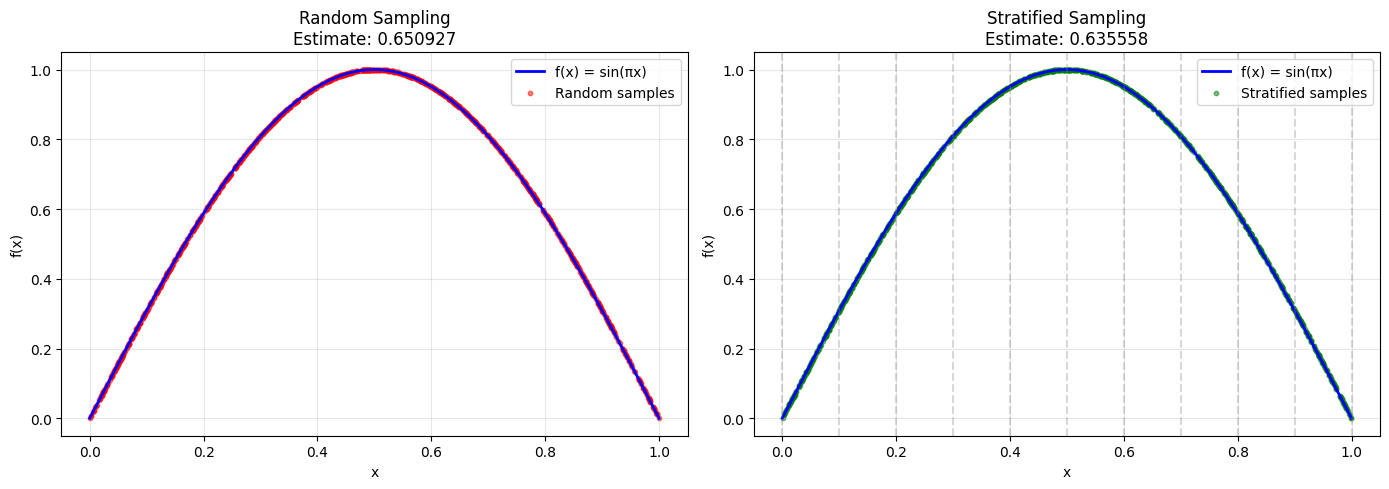

True value: 0.636620
Random sampling error: 0.014307
Stratified sampling error: 0.001062

層別サンプリングにより分散が削減されます！


In [16]:
# 層別サンプリングの例
def stratified_sampling_example():
    """
    層別サンプリングによる分散削減の実演
    """
    n_total = 1000
    n_strata = 10
    n_per_stratum = n_total // n_strata
    
    # 通常のランダムサンプリング
    x_random = np.random.uniform(0, 1, n_total)
    y_random = np.sin(np.pi * x_random)
    integral_random = np.mean(y_random)
    
    # 層別サンプリング
    x_stratified = []
    for i in range(n_strata):
        # 各層内で一様サンプリング
        stratum_start = i / n_strata
        stratum_end = (i + 1) / n_strata
        x_stratum = np.random.uniform(stratum_start, stratum_end, n_per_stratum)
        x_stratified.extend(x_stratum)
    
    x_stratified = np.array(x_stratified)
    y_stratified = np.sin(np.pi * x_stratified)
    integral_stratified = np.mean(y_stratified)
    
    # 真の値
    true_value = 2 / np.pi
    
    # プロット
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    x_plot = np.linspace(0, 1, 1000)
    y_plot = np.sin(np.pi * x_plot)
    
    # ランダムサンプリング
    ax1.plot(x_plot, y_plot, 'b-', linewidth=2, label='f(x) = sin(πx)')
    ax1.scatter(x_random, y_random, c='red', s=10, alpha=0.5, label='Random samples')
    ax1.set_xlabel('x')
    ax1.set_ylabel('f(x)')
    ax1.set_title(f'Random Sampling\nEstimate: {integral_random:.6f}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 層別サンプリング
    ax2.plot(x_plot, y_plot, 'b-', linewidth=2, label='f(x) = sin(πx)')
    ax2.scatter(x_stratified, y_stratified, c='green', s=10, alpha=0.5, 
               label='Stratified samples')
    # 層の境界を表示
    for i in range(n_strata + 1):
        ax2.axvline(x=i/n_strata, color='gray', linestyle='--', alpha=0.3)
    ax2.set_xlabel('x')
    ax2.set_ylabel('f(x)')
    ax2.set_title(f'Stratified Sampling\nEstimate: {integral_stratified:.6f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"True value: {true_value:.6f}")
    print(f"Random sampling error: {abs(integral_random - true_value):.6f}")
    print(f"Stratified sampling error: {abs(integral_stratified - true_value):.6f}")
    print(f"\n層別サンプリングにより分散が削減されます！")

stratified_sampling_example()

**参考文献**
- Metropolis, N., & Ulam, S. (1949). The monte carlo method.
- Robert, C. P., & Casella, G. (2004). Monte Carlo statistical methods.
- Rubinstein, R. Y., & Kroese, D. P. (2016). Simulation and the Monte Carlo method.